# Face Detection

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import os
import pathlib
import PIL
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib
import matplotlib.pyplot as plt
import cv2 as cv
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D, Dense,Dropout, BatchNormalization

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[0], True)
    print('GPU', tf.test.gpu_device_name(), 'configured')

GPU /device:GPU:0 configured


In [4]:
images_path = "data/faces/images"
dataset_path = "data/faces/faces.csv"

In [5]:
dataset = pd.read_csv(dataset_path)
dataset.head()

,image_name,width,height,x0,y0,x1,y1
0,00001722.jpg,1333,2000,490,320,687,664
1,00001044.jpg,2000,1333,791,119,1200,436
2,00001050.jpg,667,1000,304,155,407,331
3,00001736.jpg,626,417,147,14,519,303
4,00003121.jpg,626,418,462,60,599,166


In [6]:
dataset['image_name'].value_counts()

image_name
00000657.jpg    12
00003172.jpg    11
00003165.jpg    11
00000508.jpg    10
00000737.jpg     9
                ..
00003430.jpg     1
00003418.jpg     1
00001569.jpg     1
00002074.jpg     1
00000103.jpg     1
Name: count, Length: 2204, dtype: int64

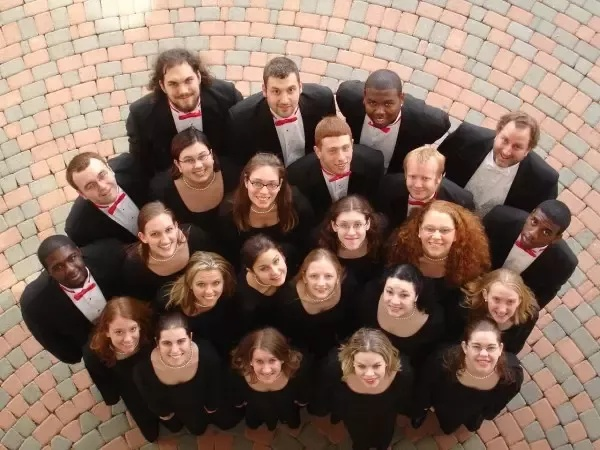

In [7]:
from IPython.display import Image

Image(filename=os.path.join(images_path, "00000657.jpg"), width=400, height=300)

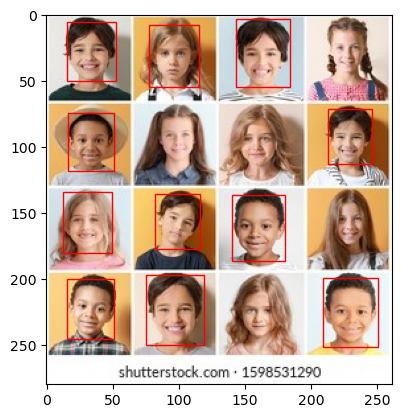

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd


# Specify the image name for which you want to draw rectangles
target_image_name = '00003172.jpg'

# Filter the DataFrame to get the relevant rows for the target image
target_df = dataset[dataset['image_name'] == target_image_name]

# Load and display the target image
image_path = os.path.join(images_path, target_image_name)  # Adjust the path to your image directory

# Create a figure and axes
fig, ax = plt.subplots(1)

image = plt.imread(image_path)
ax.imshow(image)


# Iterate over the rows of the target DataFrame and draw rectangles
for index, row in target_df.iterrows():
    x0, y0, x1, y1 = row['x0'], row['y0'], row['x1'], row['y1']
    width = x1 - x0
    height = y1 - y0
    rect = patches.Rectangle((x0, y0), width, height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.show()


In [8]:
data = {}
for i in dataset["image_name"]:
    if i not in data:
        data[i] = []
for index, img_name in enumerate(dataset["image_name"]):
    width = dataset["width"][index]
    height = dataset["height"][index]
    x0 = dataset["x0"][index]
    x1 = dataset["x1"][index]
    y0 = dataset["y0"][index]
    y1 = dataset["y1"][index]
    
    new_x0 = int((x0/width)*224)
    new_x1 = int((x1/width)*224)
    new_y0 = int((y0/width)*224)
    new_y1 = int((y1/width)*224)
    
    data[img_name].append(new_x0)
    data[img_name].append(new_x1)
    data[img_name].append(new_y0)
    data[img_name].append(new_y1)
data

{'00001722.jpg': [82, 115, 53, 111],
 '00001044.jpg': [88, 134, 13, 48],
 '00001050.jpg': [102, 136, 52, 111],
 '00001736.jpg': [52, 185, 5, 108],
 '00003121.jpg': [165,
  214,
  21,
  59,
  113,
  157,
  56,
  90,
  12,
  57,
  25,
  60,
  90,
  134,
  33,
  66,
  59,
  109,
  42,
  80],
 '00000400.jpg': [55, 140, 22, 90],
 '00002571.jpg': [27, 73, 37, 77, 139, 180, 47, 82],
 '00000366.jpg': [42, 125, 21, 87, 75, 159, 0, 35],
 '00002565.jpg': [42, 170, 7, 90],
 '00001939.jpg': [71, 140, 20, 76],
 '00001087.jpg': [88, 134, 5, 41],
 '00001093.jpg': [79, 106, 7, 57],
 '00001905.jpg': [50, 144, 7, 81],
 '00001911.jpg': [89, 125, 52, 76, 109, 161, 31, 66, 65, 116, 11, 46],
 '00002997.jpg': [68, 92, 62, 80, 94, 122, 5, 27, 144, 173, 28, 51],
 '00003451.jpg': [82, 124, 43, 114],
 '00001246.jpg': [78, 134, 11, 58],
 '00001520.jpg': [139,
  201,
  51,
  99,
  6,
  70,
  39,
  88,
  76,
  138,
  56,
  103,
  99,
  162,
  48,
  96,
  186,
  223,
  43,
  90],
 '00002029.jpg': [96, 134, 42, 108],


In [9]:
img_dir = os.listdir(images_path)
images = []
for img_name in data.keys():
    for itr in img_dir:
        if img_name == itr:
            img_arr = cv.imread(os.path.join(images_path, img_name),
                               cv.IMREAD_GRAYSCALE)
            img_resize = cv.resize(img_arr, (224, 224))
            images.append(img_resize)

In [10]:
images = np.array(images)
images = np.expand_dims(images, axis = 3)

In [11]:
print(f"Shape of images : {images.shape}")

Shape of images : (2204, 224, 224, 1)


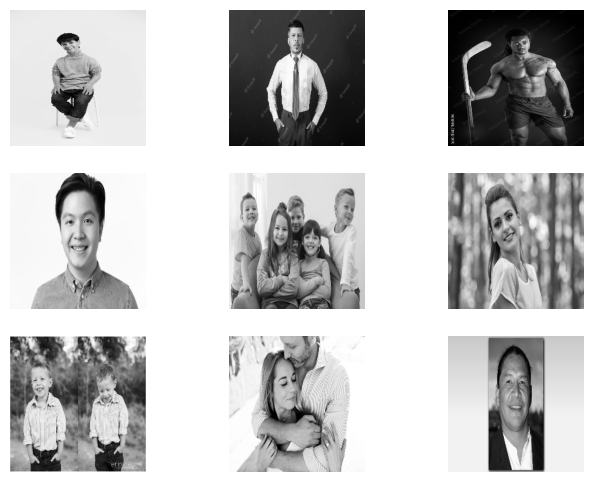

In [12]:
plt.figure(figsize = (8,6))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i], cmap = 'gray')
    plt.axis('off')

## Creating BBoxes (or Bounding Boxes) for Object Detection

In [13]:
bbox = []
for box in data.keys():
    bbox.append(data[box])

max_bbox = 0
for i in range(len(bbox)):
    max_bbox = max(max_bbox, len(bbox[i]))

for i in range(len(bbox)):
    if int(max_bbox) - len(bbox[i]) != 0:
        for j in range(int(max_bbox) - len(bbox[i])):
            bbox[i].append(0)

In [14]:
bbox = np.array(bbox)
print(bbox[0])
print(bbox[4])

[ 82 115  53 111   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0]
[165 214  21  59 113 157  56  90  12  57  25  60  90 134  33  66  59 109
  42  80   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0]


In [15]:
bbox.shape

(2204, 48)

In [16]:
# Lets normalize
images = images/255
bbox = bbox/224

In [17]:
#Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(images, bbox, test_size = 0.25, random_state = 42)

In [18]:
# Building a CNN Sequential Model

model = Sequential([
    Conv2D(32, 3, input_shape = (224,224,1), padding = "same", activation = "relu"),
    MaxPool2D(pool_size = 2),
    Conv2D(64, 3, padding = "same", activation = "relu"),
    MaxPool2D(pool_size = 2),
    Conv2D(128, 3, padding = "same", activation = "relu"),
    MaxPool2D(pool_size = 2),
    Conv2D(256, 3, padding = "same", activation = "relu"),
    MaxPool2D(pool_size = 2),
    GlobalAveragePooling2D(),
    Dense(256, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(48, activation = 'sigmoid') #output layer has 48 neurons to match the bbox dimensions
])

2023-06-30 10:46:32.931971: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-30 10:46:32.932309: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-30 10:46:32.932551: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-30 10:46:32.932796: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-30 10:46:32.932966: I tensorflow/compiler/xla/stream_executo

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 128)      0

In [20]:
model.compile(loss = 'binary_crossentropy', 
              optimizer = tf.keras.optimizers.Adam(), 
              metrics = ['accuracy'])

In [24]:
history = model.fit(X_train, y_train, 
                    validation_data = (X_test, y_test), epochs = 50)

Epoch 1/50
52/52 [==============================] - 4s 56ms/step - loss: 0.1054 - accuracy: 0.6854 - val_loss: 0.1079 - val_accuracy: 0.6806
Epoch 2/50
52/52 [==============================] - 2s 38ms/step - loss: 0.1048 - accuracy: 0.6854 - val_loss: 0.1091 - val_accuracy: 0.6806
Epoch 3/50
52/52 [==============================] - 2s 38ms/step - loss: 0.1048 - accuracy: 0.6854 - val_loss: 0.1075 - val_accuracy: 0.6806
Epoch 4/50
52/52 [==============================] - 2s 38ms/step - loss: 0.1045 - accuracy: 0.6854 - val_loss: 0.1069 - val_accuracy: 0.6806
Epoch 5/50
52/52 [==============================] - 2s 39ms/step - loss: 0.1040 - accuracy: 0.6854 - val_loss: 0.1063 - val_accuracy: 0.6806
Epoch 6/50
52/52 [==============================] - 2s 38ms/step - loss: 0.1047 - accuracy: 0.6854 - val_loss: 0.1065 - val_accuracy: 0.6806
Epoch 7/50
52/52 [==============================] - 2s 38ms/step - loss: 0.1036 - accuracy: 0.6854 - val_loss: 0.1065 - val_accuracy: 0.6806
Epoch 8/50
52

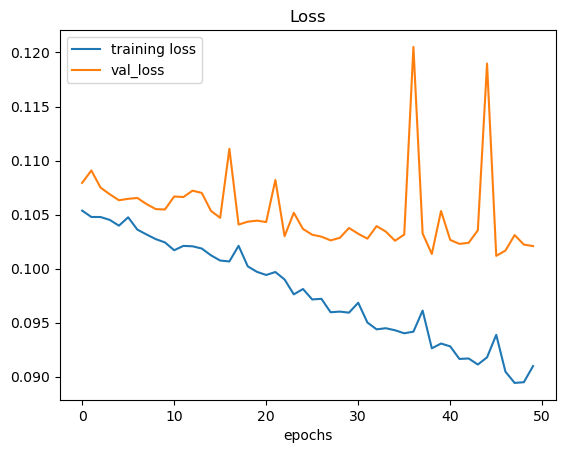

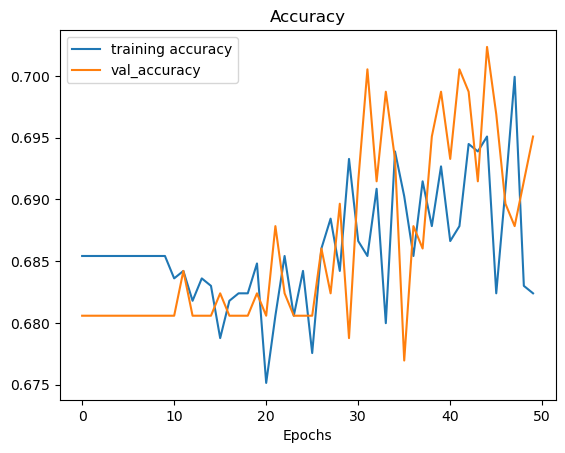

In [26]:
# Adapted from Daniel Bourke's Course on TensorFlow and Deep Learning
def plot_loss_curves(history):
    '''
    Returns separate loss curves for training and validation metrics
    '''
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss'])) #generates the sequence of indices in a list, in this case epochs

    #Plot loss
    plt.plot(epochs, loss, label = 'training loss')
    plt.plot(epochs, val_loss, label = 'val_loss')
    plt.title('Loss')
    plt.xlabel('epochs')
    plt.legend()

    #Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label = 'training accuracy')
    plt.plot(epochs, val_accuracy, label = 'val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    
plot_loss_curves(history)

In [27]:
model.evaluate(X_test, y_test, batch_size = 32)

18/18 [==============================] - 0s 15ms/step - loss: 0.1021 - accuracy: 0.6951


[0.10208805650472641, 0.6950998306274414]

## Model 2: Adding a BatchNormalisation and Dropout Layer

The Dropout Layer will set input unit frequencies to 0 at any point during training. Overfitting is thus prevented.

In [28]:
model_2 = Sequential([
    Conv2D(32, 3, input_shape = (224,224,1), activation = 'relu'),
    Dropout(0.1),
    MaxPool2D(pool_size = 2),
    BatchNormalization(),
    Conv2D(64, 3, activation = 'relu'),
    Dropout(0.2),
    MaxPool2D(pool_size = 2),
    BatchNormalization(),
    Conv2D(128, 3, activation = 'relu'),
    Dropout(0.3),
    MaxPool2D(pool_size = 2),
    BatchNormalization(),
    Conv2D(256, 3, activation = 'relu'),
    Dropout(0.4),
    MaxPool2D(pool_size = 2),
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(256, activation = 'relu'),
    Dense(48, activation = 'sigmoid') #output layer
])

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 32)      320       
                                                                 
 dropout (Dropout)           (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 111, 111, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 dropout_1 (Dropout)         (None, 109, 109, 64)     

In [29]:
model_2.compile(loss = 'binary_crossentropy',
               optimizer= tf.keras.optimizers.Adam(),
               metrics = ['accuracy'])

In [30]:
history_2 = model_2.fit(X_train, y_train, validation_data = (X_test, y_test),
           batch_size = 8, epochs = 60)

Epoch 1/60


2023-06-30 10:58:33.180425: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


207/207 [==============================] - 9s 24ms/step - loss: 0.1521 - accuracy: 0.6279 - val_loss: 0.1676 - val_accuracy: 0.6806
Epoch 2/60
207/207 [==============================] - 4s 20ms/step - loss: 0.1177 - accuracy: 0.6618 - val_loss: 0.1377 - val_accuracy: 0.6806
Epoch 3/60
207/207 [==============================] - 4s 20ms/step - loss: 0.1110 - accuracy: 0.6624 - val_loss: 0.1462 - val_accuracy: 0.6806
Epoch 4/60
207/207 [==============================] - 4s 20ms/step - loss: 0.1108 - accuracy: 0.6594 - val_loss: 0.1376 - val_accuracy: 0.6806
Epoch 5/60
207/207 [==============================] - 4s 20ms/step - loss: 0.1095 - accuracy: 0.6667 - val_loss: 0.1390 - val_accuracy: 0.6806
Epoch 6/60
207/207 [==============================] - 4s 20ms/step - loss: 0.1098 - accuracy: 0.6709 - val_loss: 0.1751 - val_accuracy: 0.6824
Epoch 7/60
207/207 [==============================] - 4s 20ms/step - loss: 0.1080 - accuracy: 0.6649 - val_loss: 0.1346 - val_accuracy: 0.6806
Epoch 8/60

207/207 [==============================] - 4s 19ms/step - loss: 0.0815 - accuracy: 0.7683 - val_loss: 0.1441 - val_accuracy: 0.7042
Epoch 59/60
207/207 [==============================] - 4s 19ms/step - loss: 0.0832 - accuracy: 0.7556 - val_loss: 0.1424 - val_accuracy: 0.6824
Epoch 60/60
207/207 [==============================] - 4s 19ms/step - loss: 0.0785 - accuracy: 0.7816 - val_loss: 0.1465 - val_accuracy: 0.6788


Slight improvement in the accuracy over the previous model.

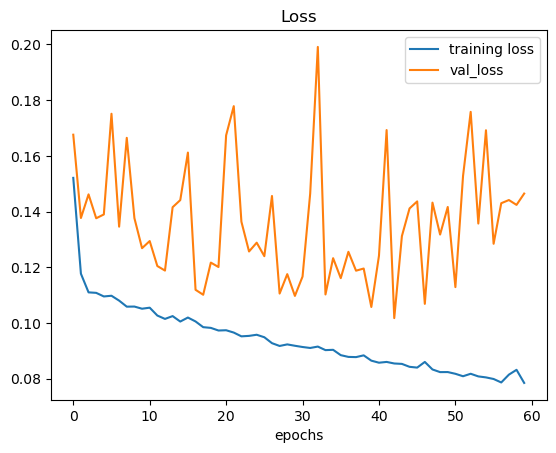

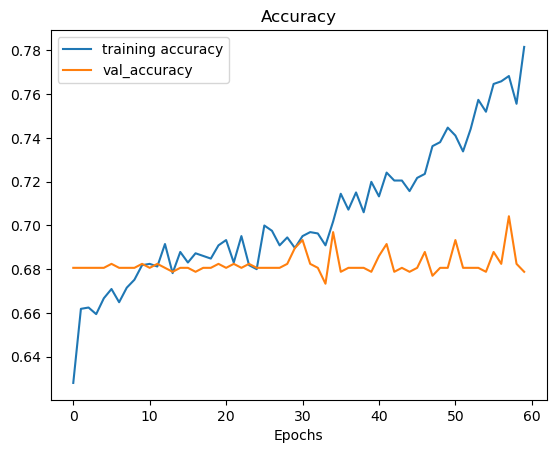

In [31]:
plot_loss_curves(history_2)

In [32]:
model_2.evaluate(X_test, y_test, batch_size = 32)

18/18 [==============================] - 0s 12ms/step - loss: 0.1465 - accuracy: 0.6788


[0.14645397663116455, 0.6787658929824829]

In [33]:
def plot_predictions(model,idx):
    '''
    Plots the decision boundary for a model on an image specified by its index.
    
    Parameters:
    
    model: The model whose predictions we are testing
    idx: The index of the image as it appears in the dataset
    '''
    model_prediction = model.predict(X_test[idx].reshape(1, 224, 224, 1))
    model_prediction = model_prediction[0]
    img = X_test[idx]
    count = 0
    bbox1 = []
    for i in model_prediction:
        bbox1.append(i)
        count+=1
        if count == 4:
            count = 0
            plt.subplot(1,2,1)
            plt.imshow(img)
            x1 = int(bbox1[0]*224)
            y1 = int(bbox1[1]*224)
            x2 = int(bbox1[2]*224)
            y2 = int(bbox1[3]*224)
            plt.gca().add_patch(matplotlib.patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth = 1,
                                                 edgecolor = 'r', facecolor = "none"))
            bbox1 = []
    plt.show()

1/1 [==============================] - 0s 22ms/step


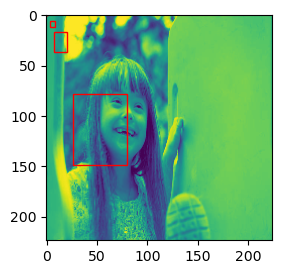

In [41]:
plot_predictions(model,4)

1/1 [==============================] - 0s 23ms/step


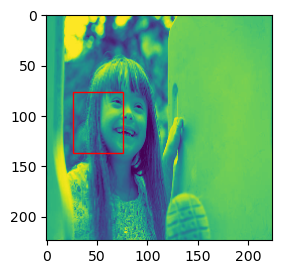

In [42]:
plot_predictions(model_2, 4)